# GFD: GPU Fractional Differencing
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ritchieng/fractional_differencing_gpu/blob/master/notebooks/gpu_fractional_differencing.ipynb)


## Summary

Typically we attempt to achieve some form of stationarity via a transformation on our time series through common methods including integer differencing. However, integer differencing unnecessarily removes too much memory to achieve stationarity. An alternative, fractional differencing, allows us to achieve stationarity while maintaining the maximum amount of memory compared to integer differencing. While existing CPU-based implementations are inefficient for running fractional differencing on many large-scale time series, our GPU-based implementation enables rapid fractional differencing.

This tutorial walks you through our GPU implementation of fractional differencing (GFD). Also, this tutorial is a special collaboration between industry and academia led by me.

## Credits

Before we start, I would like to thank and give credits for this particular post to:
1. NVIDIA (Ettikan, Chris and Nick), Amazon AWS, ensemblecap.ai, and NExT++ (NUS School of Computing)
2. Marcos Lopez de Prado  for his recent push on the use of fractional differencing of which this guide is based on.
3. Hosking for his paper in 1981 on fractional differencing.


## Links

- Code Repository: https://github.com/ritchieng/fractional_differencing_gpu
- Presentation: https://www.researchgate.net/publication/335159299_GFD_GPU_Fractional_Differencing_for_Rapid_Large-scale_Stationarizing_of_Time_Series_Data_while_Minimizing_Memory_Loss

## Installation of Libraries (Optional)
- These steps are for easily running RAPIDS in Google Colab. You can skip this section if you've [RAPIDS](https://rapids.ai/) installed.

In [0]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

print(f'Currently running on {device_name}')

if device_name != b'Tesla T4':
    raise Exception("""
    Unfortunately this instance does not have a T4 GPU.

    Please make sure you've configured Colab to request a GPU instance type.

    Sometimes Colab allocates a Tesla K80 instead of a T4. Resetting the instance.

    If you get a K80 GPU, try Runtime -> Reset all runtimes -> Keep trying!
  """)
else:
    print('Woo! You got the right kind of GPU, a Tesla T4!')

Currently running on b'Tesla T4'
Woo! You got the right kind of GPU, a Tesla T4!


In [0]:
# intall miniconda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# install RAPIDS packages
!conda install -q -y --prefix /usr/local -c conda-forge \
  -c rapidsai-nightly/label/cuda10.0 -c nvidia/label/cuda10.0 \
  cudf cuml

# set environment vars
import sys, os, shutil
sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

# copy .so files to current working dir
for fn in ['libcudf.so', 'librmm.so']:
    shutil.copy('/usr/local/lib/'+fn, os.getcwd())

--2019-08-13 02:56:34--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 

**You would need to do a `Runtime > Restart and Run All` on your Google Colab notebook at this step.**

## Imports

In [0]:
# Critical imports for GPU cuDF
import nvstrings, nvcategory, cudf

In [0]:
# Other imports
import numpy as np
import pandas as pd
import time
import seaborn as sns
import pandas_datareader.data as web
from datetime import datetime
from matplotlib import pyplot as plt
from numba import cuda

## Plotting Style

In [0]:
# Display settings: just to make it slightly prettier
# There'll be a separate post on beautiful plots
%matplotlib inline
figsize=(25, 6)
plt.style.use('fivethirtyeight')

## Necessity of Fractional Differencing
- Before we get into why fractional differencing is critical, let us inspect a simple time series pulled from the Fed's database: S&P 500.

### Pulling, Processing & Plotting SPX Time Series

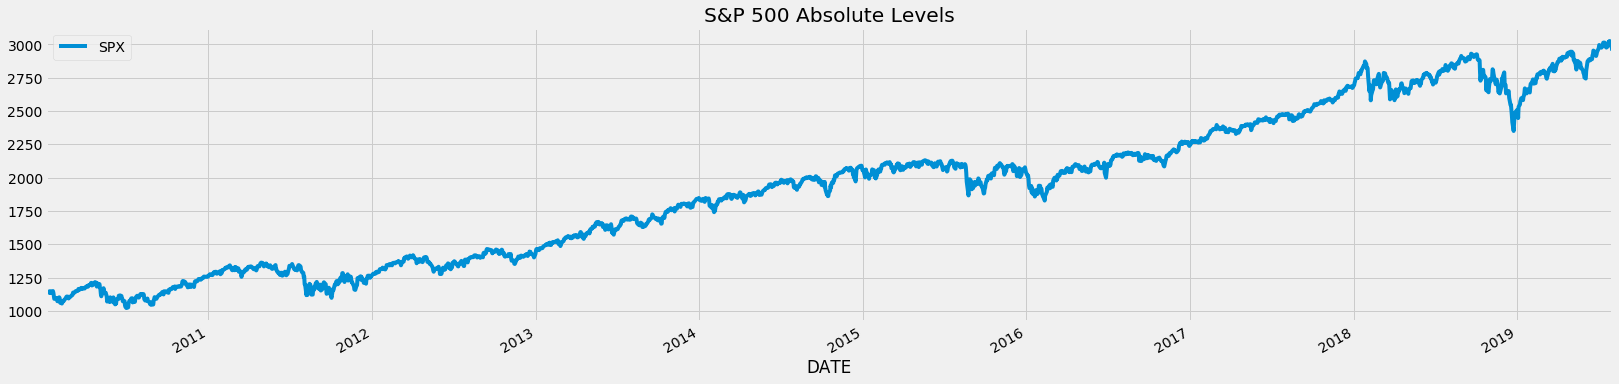

In [0]:
# Read SPX data 2010-2019 from FED database: https://fred.stlouisfed.org/categories/94
asset_name = 'SPX'
start = datetime(2010, 1, 1)
end = datetime(2019, 8, 1)
df_raw = web.DataReader('SP500', 'fred', start, end)

# Basic clean up data: dropna (there are other more robust treatments)
df_raw = df_raw.dropna()
df_raw.columns = [asset_name]

df_raw.plot(figsize=figsize)
plt.title('S&P 500 Absolute Levels');

### Integer Differencing (1 Day Returns) SPX Time Series
- Traditionally we typically might difference our time series by one day (daily returns) or more to reach some form of stationarity via tests like ADF, KPSS, PP and more.
- However, these forms of integer differencing causes more information than needed to be lost.

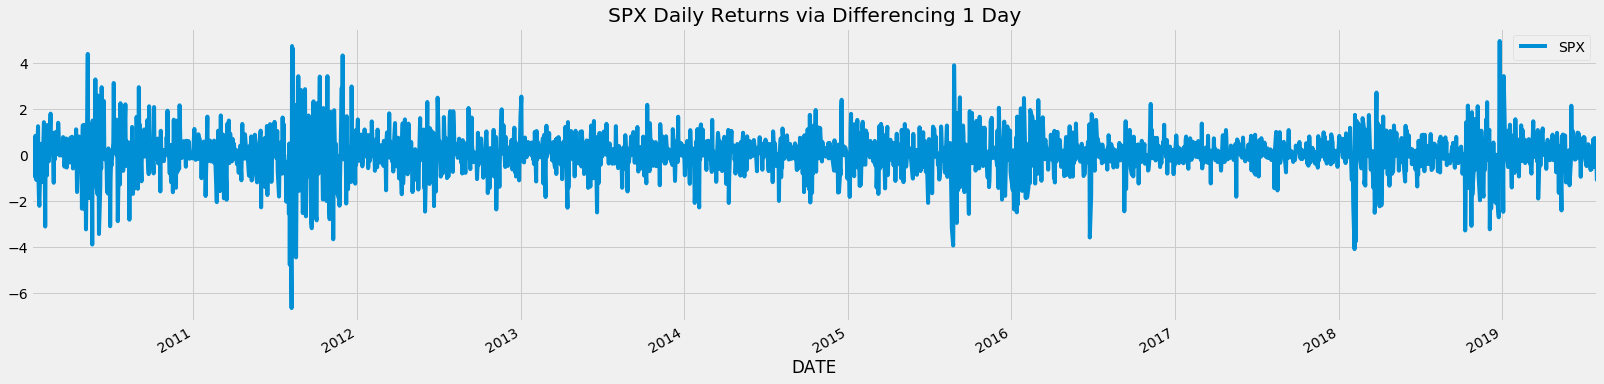

In [0]:
# One day returns calculation through differencing by 1
differencing_factor = 1
df_daily_returns = (df_raw - df_raw.shift(differencing_factor)) / df_raw.shift(differencing_factor) * 100
df_daily_returns.plot(figsize=figsize)
plt.title(f'{asset_name} Daily Returns via Differencing 1 Day');

### Integer Differencing Causes Unnecessary Memory Loss
- Because of this reason, we propose fractional differencing to achieve stationarity while minimizing memory loss.


## Basic Fractional Differencing

Fractional differencing allows us to achieve stationarity while maintaining the maximum amount of memory compared to integer differencing.

This was originally introduced in 1981 in his paper “Fractional Differencing” by J. R. M. Hosking1  and subsequent work by others concentrated on fast and efficient implementations for fractional differentiation for continuous stochastic processes.
Recently, fractional differencing was introduced for financial time series through the fixed window fractional differencing instead of the expanding window method by Marcos Lopez de Prado2.

###  Fractional Differencing Weight Function and Plot
- Weights formula: $w_k = -w_{k-1} \frac{d - k + 1}{k}$
- Weight converges to zero: $w_k \rightarrow 0$

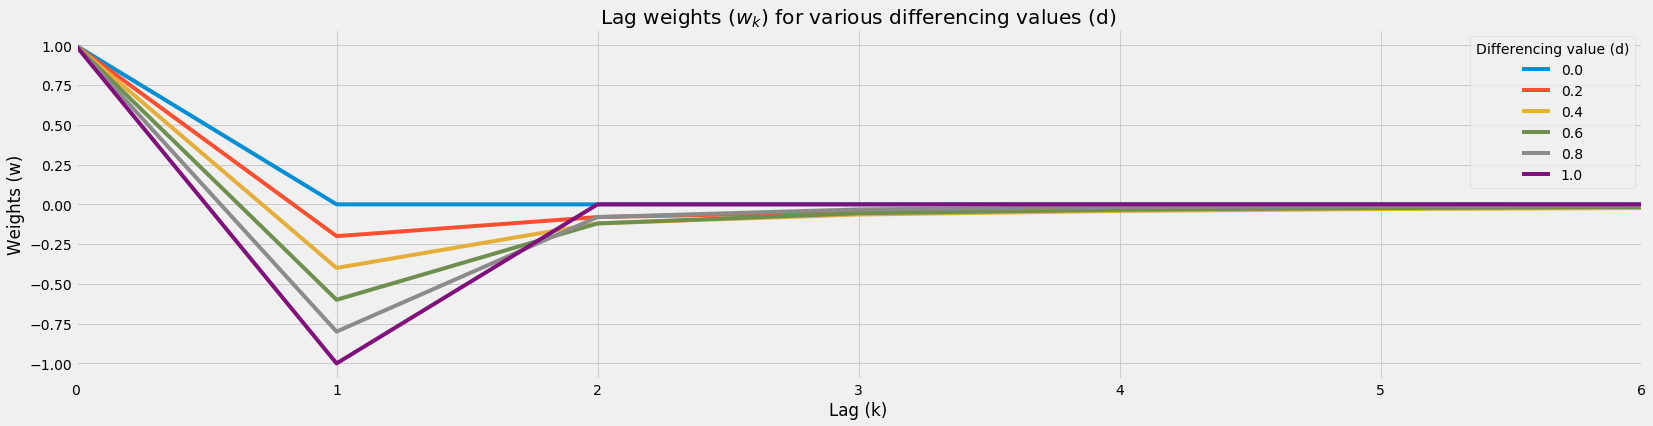

In [0]:
def get_weights(d, num_k):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
    """
    w_k = np.array([1])
    
    for k in range(1, num_k):
        w_k = np.append(w_k, -w_k[-1] * ((d - k + 1)) / k)
        
    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def plot_weights(range_d, num_k, num_d_interval):
    r"""Plot weights ($w$) for each lag ($k$) for varying differencing value ($d$).
    
    Args:
        range_d (list): range of differencing values to plot.
        num_k (int): number of lags (typically length of timeseries) to plot.
        num_d_interval (int): number of d interval.
    """
    # Get differencing values
    interval = np.linspace(range_d[0], range_d[1], num_d_interval)
    
    # Dataframe of lags (rows) x number of differencing intervals (columns)
    df_wk = pd.DataFrame(np.zeros((num_k, num_d_interval)))
    
    # Get weights array per differencing value
    for i, d in enumerate(interval):
        df_wk[i] = get_weights(d, num_k)
        
    # Rename columns for legend
    df_wk.columns = [round(x, 1) for x in interval]
    
    # Plot
    df_wk.plot(figsize=figsize)
    plt.title('Lag weights ($w_k$) for various differencing values (d)')
    plt.legend(title='Differencing value (d)')
    plt.ylabel('Weights (w)')
    plt.xlabel('Lag (k)')
    plt.show()
    
    # Return weights
    return df_wk

df_wk = plot_weights(range_d=[0, 1], num_k=7, num_d_interval=6)

###  Fractional Differencing Weight Function Table

In [0]:
# Dataframe for lag weights (w) for various differencing values (d)
df_wk

,0.0,0.2,0.4,0.6,0.8,1.0
0,1.0,1.000000,1.000000,1.000000,1.000000,1.0
1,-0.0,-0.200000,-0.400000,-0.600000,-0.800000,-1.0
2,-0.0,-0.080000,-0.120000,-0.120000,-0.080000,0.0
3,-0.0,-0.048000,-0.064000,-0.056000,-0.032000,0.0
4,-0.0,-0.033600,-0.041600,-0.033600,-0.017600,0.0
5,-0.0,-0.025536,-0.029952,-0.022848,-0.011264,0.0
6,-0.0,-0.020429,-0.022963,-0.016755,-0.007885,0.0


###  Fractional Differencing Value Calculation Toy Example
- Assume spot have values 100, 99, 98, 97, 96, 95, 94 from k=0 to k=6

#### For $d = 0$ (no differencing)

In [0]:
differenced_value = 100 * 1 + 99 * 0 + 98 * 0 + 97 * 0 + 96 * 0 + 95 * 0 + 94 * 0
print(f'Differenced value: {differenced_value}')
df_wk.iloc[:, 0]

Differenced value: 100


0    1.0
1   -0.0
2   -0.0
3   -0.0
4   -0.0
5   -0.0
6   -0.0
Name: 0.0, dtype: float64

#### For $d = 0.4$ (fractional differencing)

In [0]:
differenced_value = 100 * 1 + 99 * -0.400000 + 98 * -0.120000 + 97 * -0.064000 + 96 * -0.041600 + 95 * -0.041600 + 94 * -0.041600
print(f'Differenced value: {differenced_value}')
df_wk.iloc[:, 1]

Differenced value: 30.576000000000004


0    1.000000
1   -0.200000
2   -0.080000
3   -0.048000
4   -0.033600
5   -0.025536
6   -0.020429
Name: 0.2, dtype: float64

#### For $d = 1$ (integer differencing)

In [0]:
differenced_value = 100 * 1 + 99 * -1 + 98 * 0 + 97 * 0 + 96 * 0 + 95 * 0 + 94 * 0
print(f'Differenced value: {differenced_value}')
df_wk.iloc[:, -1]

Differenced value: 1


0    1.0
1   -1.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
Name: 1.0, dtype: float64

### Cumulative Sum of Weights Behavior
- Higher differencing value would accelerate cumulative sum weight decay
- This causes:
    1. Less information taken from further lags
    2. More information loss from further lags

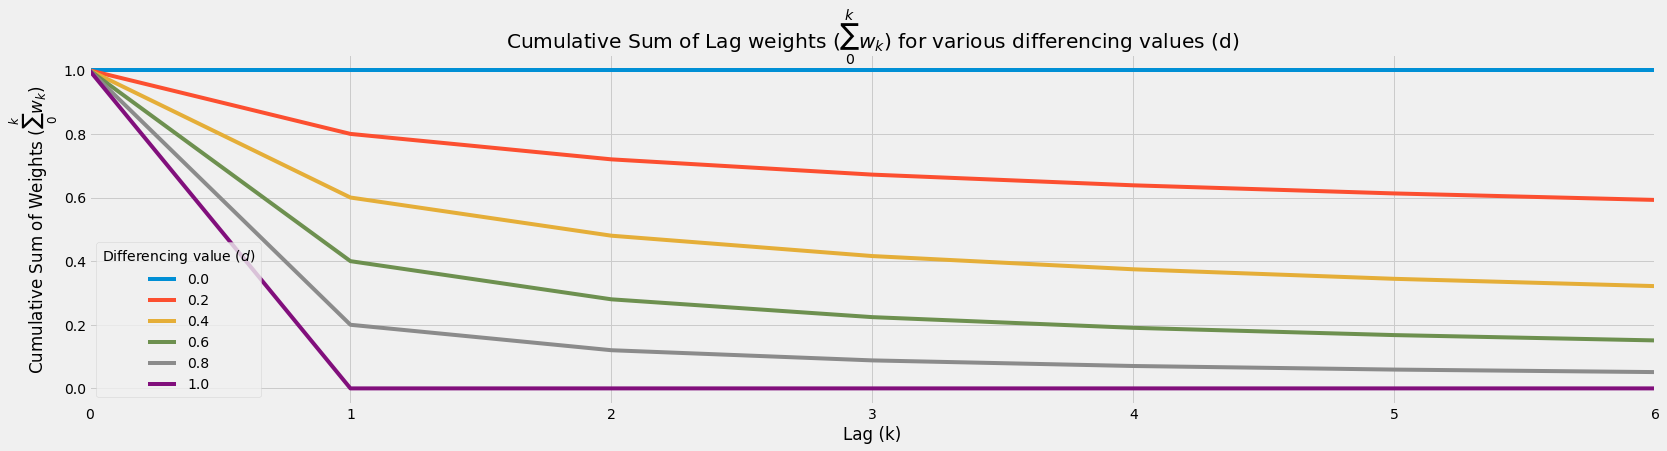

In [0]:
df_wk.cumsum().plot(figsize=figsize)
plt.title('Cumulative Sum of Lag weights ($\sum_0^k w_k$) for various differencing values (d)')
plt.legend(title='Differencing value ($d$)')
plt.ylabel('Cumulative Sum of Weights ($\sum_0^k w_k$)')
plt.xlabel('Lag (k)');

## Fixed Window Fractional Differencing (CPU)

### Floored Weights Function
- For computational efficiency, we want to stop the calculation of weights when the weights are too small (below a certain small predetermined small value).
- Image we had a time series with 1,000,000 data points, we do not want to compute the weights up till 1m lag for our latest data point!  
    - We can simply calculate the weights till they're too small which is what this function does.
   

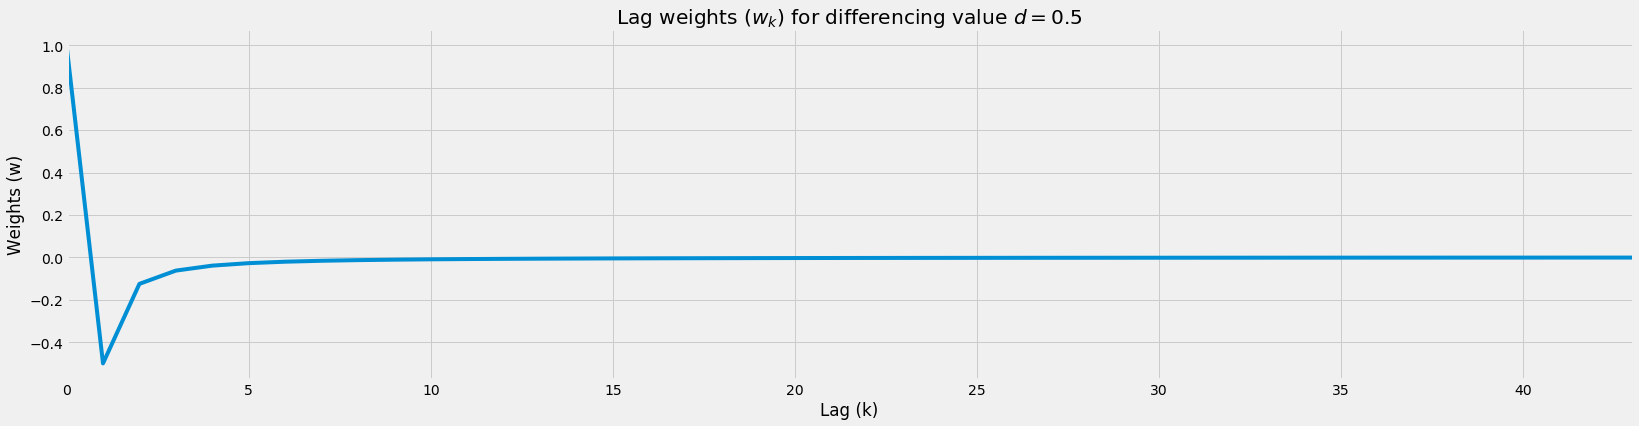

In [0]:
def get_weights_floored(d, num_k, floor=1e-3):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$ provided weight above a minimum value
    (floor) for the weights to prevent computation of weights for the entire
    time series.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
        floor (float): minimum value for the weights for computational efficiency.
    """
    w_k = np.array([1])
    k = 1
    
    while k < num_k:
        w_k_latest = -w_k[-1] * ((d - k + 1)) / k
        if abs(w_k_latest) <= floor:
            break

        w_k = np.append(w_k, w_k_latest)
        
        k += 1

    w_k = w_k.reshape(-1, 1) 
    
    return w_k

# Show large time series being stopped
# Notice how max lag is at 9?
d = 0.5
num_k = 1000
weights = get_weights_floored(d=d, num_k=num_k)
pd.DataFrame(weights).plot(legend=False, figsize=figsize)

# Plot
plt.title(f'Lag weights ($w_k$) for differencing value $d={d}$')
plt.ylabel('Weights (w)')
plt.xlabel('Lag (k)');

### Fixed Window Fractional Differencing Function (CPU)
- Here, we use the new floored weights function compared to our normal  weights function
- Calculate our differenced values through the dot product of our transposed weights matrix and our original time series within that window
    - Keep repeating by shifting the window by one time step until the end of the time series

Time 3.053557872772217 s


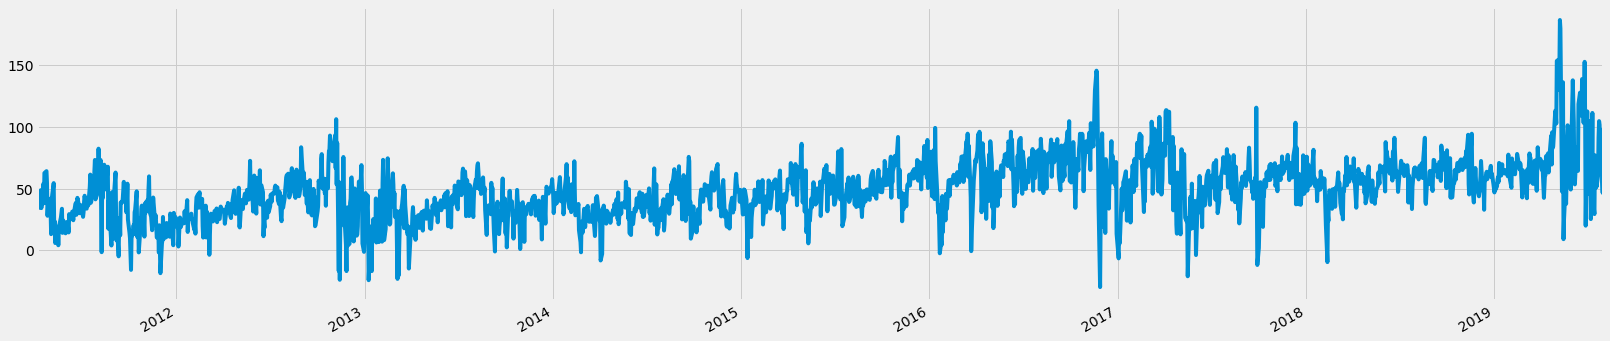

In [0]:
def frac_diff(df, d, floor=1e-3):
    r"""Fractionally difference time series via CPU.
    
    Args:
        df (pd.DataFrame): dataframe of raw time series values.
        d (float): differencing value from 0 to 1 where > 1 has no FD.
        floor (float): minimum value of weights, ignoring anything smaller.
    """
    # Get weights window
    weights = get_weights_floored(d=d, num_k=len(df), floor=floor)
    weights_window_size = len(weights)
    
    # Blank fractionally differenced series to be filled
    df_fd = pd.Series()

    # Slide window of time series, to calculated fractionally differenced values
    # per window
    for idx in range(weights_window_size, df.shape[0]):
        # Dot product of weights and original values
        # to get fractionally differenced values
        date_idx = df.index[idx]
        df_fd[date_idx] = np.dot(weights.T, df.iloc[idx - weights_window_size:idx]).item()
    
    # Return FD values and weights
    return df_fd, weights


# Start timer
start = time.time()

df_raw_fd, weights = frac_diff(df_raw, d=0.5, floor=5e-5)

# End timer
end = time.time()

print(f'Time {end-start} s')
    
# Plot
df_raw_fd.plot(figsize=figsize);

In [0]:
import multiprocessing
multiprocessing.cpu_count()

2

Existing CPU-based implementations are inefficient for running fractional differencing on many large-scale time-series. GPU-based implementations provide an avenue to adapt to this century’s big data requirements.



### Fixed Window Fractional Differencing Function (GPU) >7x Speedup
- This gives more than 7x speed-up on an NVIDIA T4 on Google Colab. 
- If you've the best GPUs with an accompanying machine, you can easily substantially increase the speed-up.
- This code can be optimized further but it'll be too complicated for most users to quickly grasp the idea of speeding up existing CPU-based implementations which is the point of this lesson. So try to improve this further yourself and maybe ping me, I'll post the best speed-up solution!


Time 0.3530001640319824 s


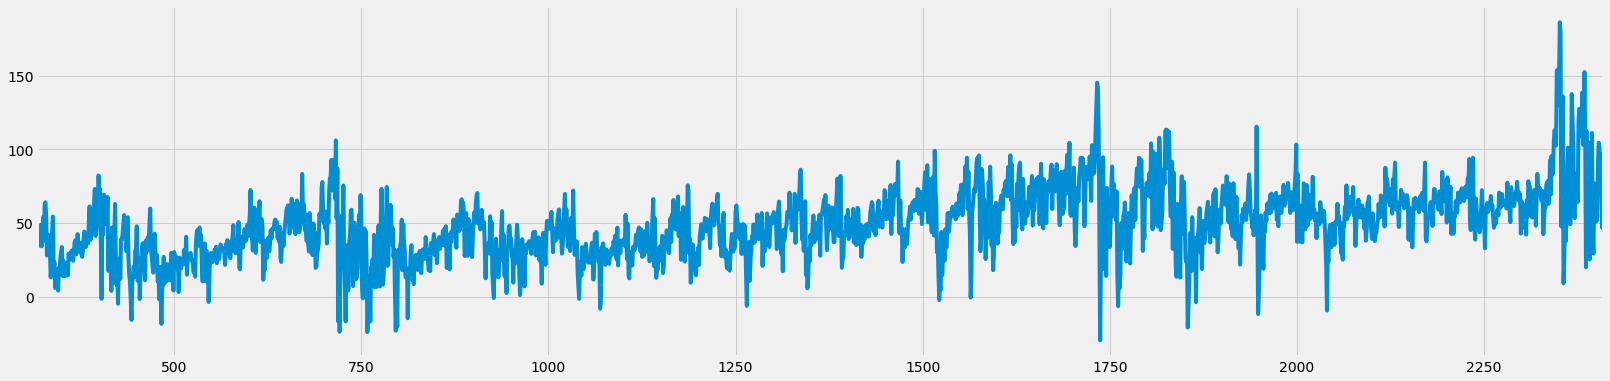

In [0]:
def moving_dot_product_kernel(in_data, out, window_size, weights):
    # Set the first window_size-1 rows in each chunk to np.nan due 
    # insufficient history
    for i in range(cuda.threadIdx.x, window_size - 1, cuda.blockDim.x):
        out[i] = np.nan
    
    # Compute dot product of preceding window_size rows
    for i in range(cuda.threadIdx.x + window_size - 1, in_data.size, cuda.blockDim.x):
        rolling_dot_product = 0.0
        
        k = 0
        for j in range(i - window_size + 1, i + 1):
            rolling_dot_product += in_data[j] * weights[k][0]
            k += 1
        
        out[i] = rolling_dot_product 
        
def frac_diff_gpu(df, d, floor=1e-3):
    r"""Fractionally difference time series via GPU.
    
    Args:
        df (pd.DataFrame): dataframe of raw time series values.
        d (float): differencing value from 0 to 1 where > 1 has no FD.
        floor (float): minimum value of weights, ignoring anything smaller.
    """
    
    # Bring dataframe to GPU, reset index for GPU dot product kernel
    gdf_raw = cudf.from_pandas(df).reset_index(drop=True)
    gdf_raw.columns = ['in_data']

    # Get weights window
    weights = get_weights_floored(d=d, num_k=len(gdf_raw), floor=floor)
    weights_window_size = len(weights)
    # Bring weights to GPU
    gdf_weights = cudf.DataFrame()
    gdf_weights[gdf_raw.columns[0]] = weights.reshape(-1,)

    # Length of data
    data_length = len(gdf_raw)

    # It seems here, T4 supports max of 518 threads per block.
    # For other GPUs, it might be higher at 1024 to 2048 like the V100s
    threads_per_block = 518

    # Chunk size split
    trunk_size = 10240

    df = cudf.DataFrame()
    df['in_data'] = np.arange(data_length, dtype=np.float64)
        
    # Get fractionally differenced time series through GPU function
    gdf_raw_fd = gdf_raw.apply_chunks(moving_dot_product_kernel,
                                 incols=['in_data'],
                                 outcols=dict(out=np.float64),
                                 kwargs=dict(window_size=weights_window_size, weights=weights),
                                 chunks=list(range(0, data_length, trunk_size)) + [data_length],
                                 tpb=threads_per_block)
    
    # Bring to CPU for normal manipulation
    df_raw_fd = gdf_raw_fd.to_pandas().dropna().iloc[:-1, 1]
    
    return df_raw_fd, weights


# Start timer
start = time.time()

df_raw_fd_from_gpu, weights = frac_diff_gpu(df_raw, d=0.5, floor=5e-5)

# End timer
end = time.time()

print(f'Time {end-start} s')

# Plot
df_raw_fd_from_gpu.plot(figsize=figsize);

### Check Values 

In [0]:
# Compare tail values
print('Tail values check')
print(df_raw_fd_from_gpu.tail().values)
print(df_raw_fd.tail().values)

Tail values check
[81.39556027 96.9161575  55.25931352 46.48580715 74.28853901]
[81.39556027 96.9161575  55.25931352 46.48580715 74.28853901]


In [0]:
# Compare tail values
print('Head values check')
print(df_raw_fd_from_gpu.head().values)
print(df_raw_fd.head().values)

Head values check
[33.36928193 36.19407302 34.58719884 38.05313633 41.71899615]
[33.36928193 36.19407302 34.58719884 38.05313633 41.71899615]


In [0]:
num_rows_true = (df_raw_fd.values.astype(np.float32) == df_raw_fd_from_gpu.values.astype(np.float32)).astype(int).sum()
total_rows = df_raw_fd.shape[0]

print(f'Number of rows equal: {num_rows_true}')
print(f'Total number of rows: {total_rows}')

Number of rows equal: 2093
Total number of rows: 2093


## Stationarity
- "A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time", [Robert Nau, Duke University](https://people.duke.edu/~rnau/411diff.htm)
- Essentially what we are trying to do here with fractional differencing is to attempt to have a stationary time series without losing too much memory.
- There are many ways to check if a time series is stationary, but we will be using 1 test here (they're more, but it's not the purpose of this tutorial)
    - Augmented Dickey–Fuller (ADF) test: check for unit root


### ADF Test

In [0]:
# Import adf/kpss
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")  # Ignore deprecations for cleaner output

#### ADF: raw data (d=0)

In [0]:
# ADF on raw data

print('Stationarity Test for SPX Absolute Levels (d=0)')
print('-'*50)

result = adfuller(df_raw['SPX'], regression='c')

print(f't-stat \n\t{result[0]:.2f}')
print(f'p-value \n\t{result[1]:.2f}')
print(f'Critical Values')
for key, value in result[4].items():
	print(f'\t{key}: {value:.2f}')
    
# test statistic > test statistic (1%) AND p-value > 0.01
# Fail to reject the null hypothesis that there's unit root at the 1% significance level
# ==> Fail to reject H0 ==> Unit root ==> Non-stationary

Stationarity Test for SPX Absolute Levels (d=0)
--------------------------------------------------
t-stat 
	-0.11
p-value 
	0.95
Critical Values
	1%: -3.43
	5%: -2.86
	10%: -2.57


#### ADF: daily return data (d=1)

In [0]:
# ADF on 1 day returns (d=1)

print('Stationarity Test for SPX Daily Returns (d=1)')
print('-'*50)
result = adfuller(df_raw['SPX'].pct_change(1).dropna(), regression='c')

print(f't-stat \n\t{result[0]:.2f}')
print(f'p-value \n\t{result[1]:.2f}')
print(f'Critical Values')
for key, value in result[4].items():
	print(f'\t{key}: {value:.2f}')
    
# test statistic < test statistic (1%) AND p-value < 0.01
# Reject the null hypothesis that there's unit root at the 1% significance level
# ==> Reject H0 ==> No unit root ==> Stationary

Stationarity Test for SPX Daily Returns (d=1)
--------------------------------------------------
t-stat 
	-11.12
p-value 
	0.00
Critical Values
	1%: -3.43
	5%: -2.86
	10%: -2.57


#### ADF: fractionally differenced data (d=0.5)

In [0]:
# ADF on fractionally differenced values

print('Stationarity Test (ADF) for SPX Fractionally Differenced (d=0.5)')
print('-'*50)


df_raw_fd_from_gpu, weights = frac_diff_gpu(df_raw, d=0.5, floor=5e-5)

result = adfuller(df_raw_fd_from_gpu, regression='c')

print(f't-stat \n\t{result[0]:.2f}')
print(f'p-value \n\t{result[1]:.2f}')
print(f'Critical Values')
for key, value in result[4].items():
	print(f'\t{key}: {value:.2f}')
    
# test statistic < test statistic (1%) AND p-value < 0.01
# Reject the null hypothesis that there's unit root at the 1% significance level
# ==> Reject H0 ==> No unit root ==> Stationary

Stationarity Test (ADF) for SPX Fractionally Differenced (d=0.5)
--------------------------------------------------
t-stat 
	-4.38
p-value 
	0.00
Critical Values
	1%: -3.43
	5%: -2.86
	10%: -2.57
